# Denoising Diffusion Probabilistic Models with miniai

## Imports

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

## Load the dataset

In [ ]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[x] = [TF.resize(TF.to_tensor(o), (32,32)) for o in b[x]]

# bs = 512
bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dt = dls.train
xb,yb = next(iter(dt))

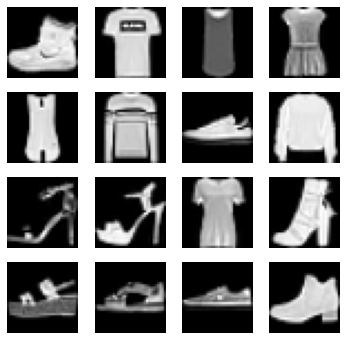

In [ ]:
show_images(xb[:16], imsize=1.5)

In [ ]:
betamin,betamax,n_steps = 0.0001,0.02,1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta 
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

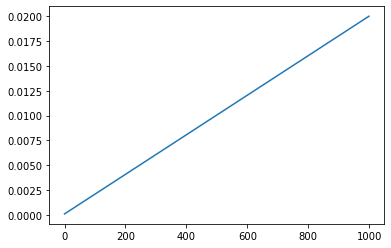

In [ ]:
plt.plot(beta);

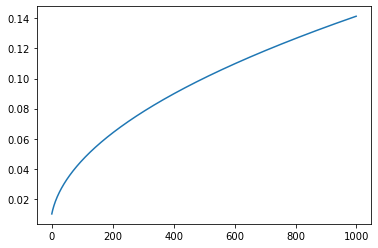

In [ ]:
plt.plot(sigma);

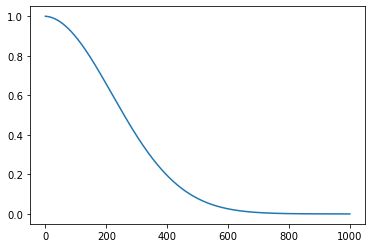

In [ ]:
plt.plot(alphabar);

In [ ]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [ ]:
(xt,t),ε = noisify(xb[:25],alphabar)
t

tensor([358, 968, 648, 763, 347, 314, 856, 119, 719, 397,  70,  83, 973, 180,
         92, 179, 617, 644,  42, 963, 434, 807,  94,  46, 231])

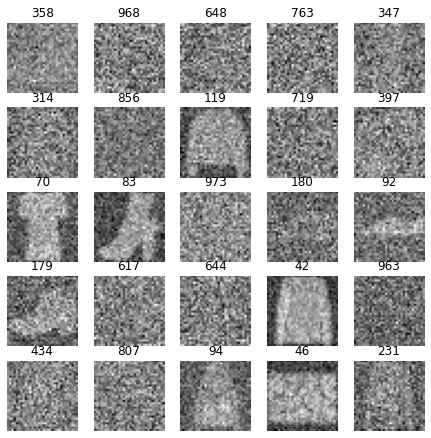

In [ ]:
titles = fc.map_ex(t, '{}')
show_images(xt, imsize=1.5, titles=titles)

## Create model

In [ ]:
from diffusers import UNet2DModel

In [ ]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [ ]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)

## Training

In [ ]:
class DDPMCB(Callback):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        fc.store_attr()
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps) # variance schedule, linearly increased with timestep
        self.α = 1. - self.beta 
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.beta.sqrt()
    
    def before_batch(self, learn): learn.batch = noisify(learn.batch[0], self.ᾱ)
    
    @torch.no_grad()
    def sample(self, model, sz):
        device = next(model.parameters()).device
        x_t = torch.randn(sz, device=device)
        preds = []
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
            ᾱ_t1 = self.ᾱ[t-1]  if t > 0 else torch.tensor(1)
            b̄_t = 1 - self.ᾱ[t]
            b̄_t1 = 1 - ᾱ_t1
            x_0_hat = ((x_t - b̄_t.sqrt() * learn.model((x_t, t_batch)))/self.ᾱ[t].sqrt()).clamp(-1,1)
            x_t = x_0_hat * ᾱ_t1.sqrt()*(1-self.α[t])/b̄_t + x_t * self.α[t].sqrt()*b̄_t1/b̄_t + self.σ[t]*z
            preds.append(x_t.cpu())
        return preds

In [ ]:
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)

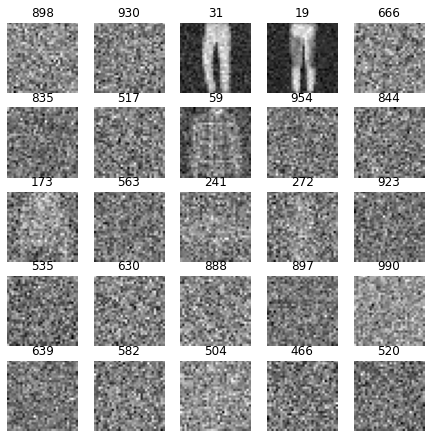

In [ ]:
learn = TrainLearner(model, dls, nn.MSELoss())
learn.fit(train=False, cbs=[ddpm_cb,SingleBatchCB()])
(xt,t),ε = learn.batch
show_images(xt[:25], titles=fc.map_ex(t[:25], '{}'), imsize=1.5)

In [ ]:
lr = 4e-3
epochs = 4

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]

In [ ]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
learn = TrainLearner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=optim.Adam)

loss,epoch,train
0.094,0,train
0.023,0,eval
0.022,1,train
0.020,1,eval
0.019,2,train
0.017,2,eval
0.017,3,train
0.016,3,eval


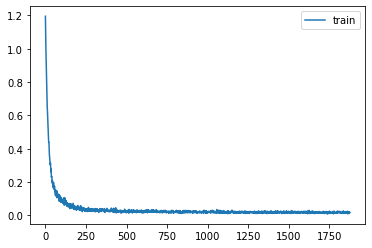

In [ ]:
learn.fit(epochs)

In [ ]:
mdl_path = Path('models')

In [ ]:
torch.save(learn.model, mdl_path/'fashion_ddpm2.pkl')

In [ ]:
learn.model = torch.load(mdl_path/'fashion_ddpm2.pkl')

## Sampling

In [ ]:
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))

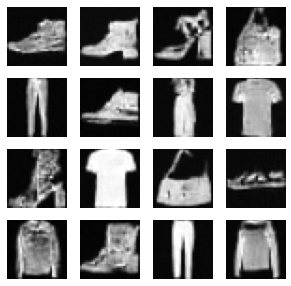

In [ ]:
show_images(samples[-1], figsize=(5,5))

In [ ]:
preds = learn.model(to_device((xt,t))).cpu()[:25]

## Mixed Precision

In [ ]:
bs = 1024
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

In [ ]:
class MixedPrecision(TrainCB):
    order = DeviceCB.order+10
    
    def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()

    def before_batch(self, learn):
        self.autocast = torch.autocast("cuda", dtype=torch.float16)
        self.autocast.__enter__()

    def after_loss(self, learn): self.autocast.__exit__(None, None, None)
        
    def backward(self, learn): self.scaler.scale(learn.loss).backward()

    def step(self, learn):
        self.scaler.step(learn.opt)
        self.scaler.update()

In [ ]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)

In [ ]:
lr = 4e-3
epochs = 8
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [ddpm_cb, DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=optim.Adam)

loss,epoch,train
0.379,0,train
0.079,0,eval
0.053,1,train
0.039,1,eval
0.033,2,train
0.028,2,eval
0.026,3,train
0.025,3,eval
0.023,4,train
0.022,4,eval


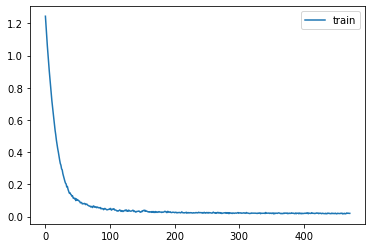

In [ ]:
learn.fit(epochs)

## Accelerate

`pip install accelerate` before running this section.

In [ ]:
from accelerate import Accelerator

In [ ]:
class AccelerateCB(TrainCB):
    order = DeviceCB.order+10
    def __init__(self, mixed_precision="fp16"): self.acc = Accelerator(mixed_precision=mixed_precision)
        
    def before_fit(self, learn):
        learn.model,learn.opt,learn.dls.train,learn.dls.valid = self.acc.prepare(
            learn.model, learn.opt, learn.dls.train, learn.dls.valid)

    def backward(self, learn): self.acc.backward(learn.loss)

In [ ]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)

In [ ]:
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=optim.Adam)

loss,epoch,train
0.354,0,train
0.097,0,eval
0.063,1,train
0.040,1,eval
0.036,2,train
0.029,2,eval
0.028,3,train
0.026,3,eval
0.024,4,train
0.024,4,eval


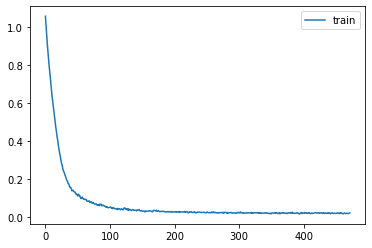

In [ ]:
learn.fit(epochs)